<a href="https://colab.research.google.com/github/DaiVo20/Question-answering-in-BoolQ/blob/main/Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install and import library**

In [3]:
!pip install transformers -Uqq

In [4]:
!pip install datasets -Uqq

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import random
import torch
import time
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import gc

gc.collect()
torch.cuda.empty_cache()

# **Load data**

In [15]:
from google.colab import drive
drive._mount('/content/drive')

path_model = os.path.join('/content/drive/MyDrive/Colab/XuLyNgonNguTuNhien/DoAn', 'bert-base-uncased.pt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
dataset = load_dataset('boolq')

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/952 [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.53M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset boolq downloaded and prepared to /root/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
train_data = pd.DataFrame(dataset['train'])
dev_data = pd.DataFrame(dataset['validation'])
data = pd.concat([train_data, dev_data], ignore_index=True)

In [10]:
data

,question,answer,passage
0,do iran and afghanistan speak the same language,True,"Persian (/ˈpɜːrʒən, -ʃən/), also known by its ..."
1,do good samaritan laws protect those who help ...,True,Good Samaritan laws offer legal protection to ...
2,is windows movie maker part of windows essentials,True,Windows Movie Maker (formerly known as Windows...
3,is confectionary sugar the same as powdered sugar,True,"Powdered sugar, also called confectioners' sug..."
4,is elder scrolls online the same as skyrim,False,As with other games in The Elder Scrolls serie...
...,...,...,...
12692,is manic depression the same as bi polar,True,"Bipolar disorder, previously known as manic de..."
12693,was whiskey galore based on a true story,True,SS Politician was an 8000-ton cargo ship owned...
12694,are there plants on the international space st...,True,Plant research continued on the International ...
12695,does the hockey puck have to cross the line to...,True,"In ice hockey, a goal is scored when the puck ..."


In [11]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
dev_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

# **Prepare data**



In [12]:
passages_train = train_data['passage'].values
questions_train = train_data['question'].values
answers_train = train_data['answer'].values.astype(int)

passages_test = test_data['passage'].values
questions_test = test_data['question'].values
answers_test = test_data['answer'].values.astype(int)

passages_dev = dev_data['passage'].values
questions_dev = dev_data['question'].values
answers_dev = dev_data['answer'].values.astype(int)

# **Train model**

In [16]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") 

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")
model.to(DEVICE)

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
def encode_data(tokenizer, questions, passages, max_length):
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

In [20]:
# Encoding data
max_seq_length = 256
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)
input_ids_test, attention_masks_test = encode_data(tokenizer, questions_test, passages_test, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)
test_features = (input_ids_test, attention_masks_test, answers_test)

In [21]:
batch_size = 32

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]
test_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in test_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)
test_dataset = TensorDataset(*test_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)
test_sampler = SequentialSampler(test_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

In [22]:
epochs = 10
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for epoch in tqdm(range(epochs), desc="Epoch"):
    # Training
    start = time.perf_counter()
    epoch_train_loss = 0
    model.train()
    model.zero_grad()

    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(DEVICE)
        attention_masks = batch[1].to(DEVICE)
        labels = batch[2].to(DEVICE)     

        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()

        loss.backward()
        
        if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
            optimizer.step()
            model.zero_grad()

    epoch_train_loss = epoch_train_loss / len(train_dataloader)          
    train_loss_values.append(epoch_train_loss)
    
    # Evaluation
    epoch_dev_accuracy = 0
    model.eval()

    for batch in dev_dataloader:
      
        input_ids = batch[0].to(DEVICE)
        attention_masks = batch[1].to(DEVICE)
        labels = batch[2]

        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
        
        epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

    epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
    dev_acc_values.append(epoch_dev_accuracy)

    end = time.perf_counter()
    print(f'Epoch {epoch + 1}/{epochs}\tTrain loss: {epoch_train_loss:.4f}\tDev accuracy: {epoch_dev_accuracy:.4f}')
    print(f'Time: {end - start:.2f}s')
    
print('Finished training!')

Epoch:  10%|█         | 1/10 [13:42<2:03:23, 822.66s/it]

Epoch 1/10	Train loss: 0.6421	Dev accuracy: 0.6865
Time: 822.66s


Epoch:  20%|██        | 2/10 [27:24<1:49:35, 821.90s/it]

Epoch 2/10	Train loss: 0.5644	Dev accuracy: 0.7158
Time: 821.37s


Epoch:  30%|███       | 3/10 [41:05<1:35:51, 821.71s/it]

Epoch 3/10	Train loss: 0.4598	Dev accuracy: 0.7210
Time: 821.49s


Epoch:  40%|████      | 4/10 [54:46<1:22:08, 821.45s/it]

Epoch 4/10	Train loss: 0.3489	Dev accuracy: 0.7260
Time: 821.04s


Epoch:  50%|█████     | 5/10 [1:08:28<1:08:27, 821.46s/it]

Epoch 5/10	Train loss: 0.2614	Dev accuracy: 0.7229
Time: 821.47s


Epoch:  60%|██████    | 6/10 [1:22:08<54:45, 821.27s/it]  

Epoch 6/10	Train loss: 0.1980	Dev accuracy: 0.7283
Time: 820.92s


Epoch:  70%|███████   | 7/10 [1:35:49<41:03, 821.20s/it]

Epoch 7/10	Train loss: 0.1624	Dev accuracy: 0.7295
Time: 821.04s


Epoch:  80%|████████  | 8/10 [1:49:30<27:21, 820.91s/it]

Epoch 8/10	Train loss: 0.1292	Dev accuracy: 0.7237
Time: 820.28s


Epoch:  90%|█████████ | 9/10 [2:03:10<13:40, 820.70s/it]

Epoch 9/10	Train loss: 0.1137	Dev accuracy: 0.7229
Time: 820.23s


Epoch: 100%|██████████| 10/10 [2:16:50<00:00, 821.09s/it]

Epoch 10/10	Train loss: 0.0989	Dev accuracy: 0.7283
Time: 820.39s
Finished training!


In [23]:
torch.save(model, path_model)

In [ ]:
model = torch.load(path_model)

In [24]:
# Evaluation on test set
# test_accuracy = 0
num_classes = 2
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    # confusion_matrix = torch.zeros(num_classes, num_classes)
    for batch in test_dataloader:
      
        input_ids = batch[0].to(DEVICE)
        attention_masks = batch[1].to(DEVICE)
        labels = batch[2]
    
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)
                        
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
        y_true = np.concatenate((y_true, labels))
        y_pred = np.concatenate((y_pred, predictions))
        
        # test_accuracy += np.sum(predictions == labels) / len(labels)
        
        # for t, p in zip(labels, predictions):
        #     confusion_matrix[t, p] += 1

    # test_accuracy = test_accuracy / len(test_dataloader)
    # print('Accuracy:', test_accuracy)
    # print('Confusion maxtrix:\n', confusion_matrix)

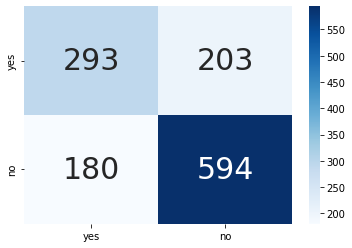

In [25]:
labels = ['yes', 'no']
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.clf()
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g', cbar=True, annot_kws={"size": 30})

In [26]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Accuracy: {:.4f}".format(acc))
print("F1: {:.4f}".format(f1))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))

Accuracy: 0.6984
F1: 0.7562
Precision: 0.7453
Recall: 0.7674


# **Predict**

In [27]:
def predict(question, passage):
    with torch.no_grad():
        encoded_data = tokenizer.encode_plus(question, passage,
                                            max_length=max_seq_length,
                                            pad_to_max_length=True,
                                            add_special_tokens=True,
                                            return_token_type_ids=False,
                                            return_attention_mask=True,
                                            return_tensors='pt',)
        input_id = encoded_data["input_ids"].to(DEVICE)
        attention_mask = encoded_data["attention_mask"].to(DEVICE)

        output = model(input_id, token_type_ids=None, attention_mask=attention_mask)
        _, prediction = torch.max(output[0], dim=1)
        return True if prediction.cpu().numpy()[0] else False

In [28]:
data_point = test_data.sample().values[0]
question = data_point[0]
passage = data_point[2]
answer_true = data_point[1]

In [30]:
print("Question:", question)
print("==============================================")
print("Passage:", passage)
print("==============================================")
print("Answer:", answer_true)

Question: can you cross a zebra with a donkey
Passage: A zebroid (also zedonk, zenkey, zorse, zebra mule, zonkey, and zebmule) is the offspring of any cross between a zebra and any other equine: essentially, a zebra hybrid. In most cases, the sire is a zebra stallion. Offspring of a donkey sire and zebra dam, called a zebra hinny, or donkra, do exist but are rare and are usually sterile and infertile. Zebroids have been bred since the 19th century. Charles Darwin noted several zebra hybrids in his works.
Answer: True


In [31]:
result = predict(question, passage)
print("Predict:", result)

Predict: True
